In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import skew, kurtosis, norm
import yfinance as yf
import os
import warnings
warnings.filterwarnings("ignore")

# Simulación de Trayectorias de Precios con Movimiento Geométrico Browniano (GBM)
-------------------------------------------------------------------------------

## Proyecto por: Javier Fernández Guerra

Este notebook tiene como objetivo modelar la evolución de precios de un activo financiero mediante un **Proceso Estocástico de Movimiento Geométrico Browniano (Geometric Brownian Motion, GBM)**.  
Se calculan estadísticos descriptivos, medidas de riesgo (VaR, CVaR, Drawdown máximo) y se generan visualizaciones de trayectorias simuladas y distribuciones finales.


El flujo de trabajo incluye:

1. **Descarga de datos históricos** y cálculo de retornos logarítmicos.  
2. **Estimación de parámetros** del modelo (media y volatilidad).  
3. **Simulación de trayectorias**:

   - <u>Solución exacta del GBM</u>:

      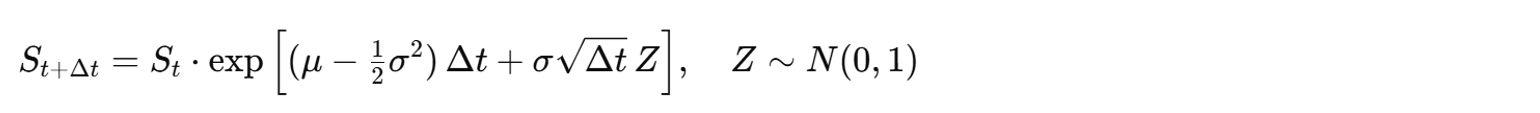


     Este método utiliza la solución analítica del GBM, sin error de discretización.

4. **Análisis estadístico y medidas de riesgo:**

   - <u>Value at Risk (VaR)</u>:

     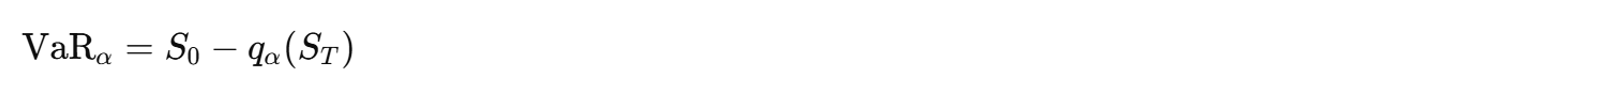

   - <u>Conditional VaR (CVaR)</u>:

     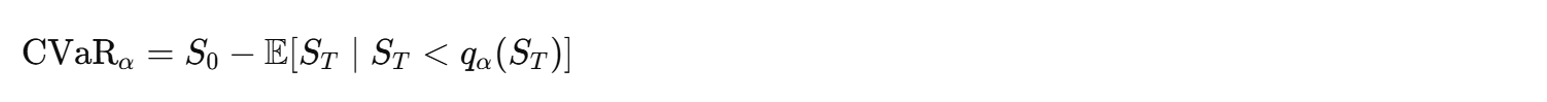

   - <u>Máximo Drawdown (%) </u>:
   
    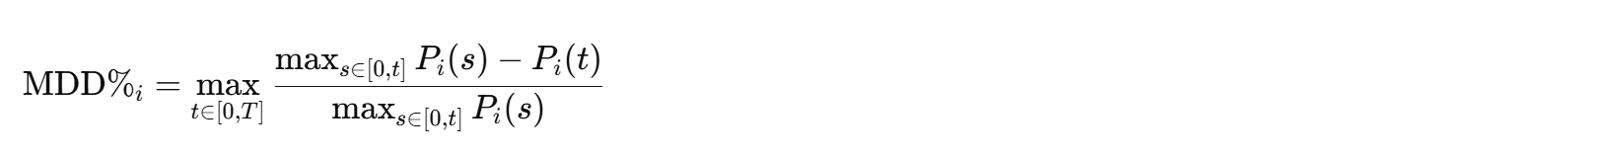

------------------------------------------------------------------------------

### A. Configuración inicial de la simulación

En este bloque definimos los **parámetros principales** para la simulación del precio del S&P 500 usando un proceso Geométrico Browniano (GBM):

- `T_trading_days`: horizonte temporal en días hábiles (un año típico).  
- `start_date`: fecha de inicio para descargar la serie histórica.  
- `ticker`: símbolo del activo a analizar (en este caso, el S&P 500 desde Yahoo Finance).  
- `seed`: semilla para asegurar reproducibilidad de los resultados.   
- `dt`: tamaño del paso temporal en días para la simulación.  
- `n_trajectories`: número de trayectorias Monte Carlo a generar.    
- `alpha`: nivel de confianza para calcular **VaR** y **CVaR** (e.j.: 0.01 → 99% de confiabilidad).


In [11]:
T_trading_days = 252            # horizonte en días hábiles
start_date = "2020-03-23"       # fecha de inicio de la serie histórica
ticker = "^GSPC"                # S&P 500 (Yahoo)
seed = 42                       # semilla reproducible (None para aleatorio)
dt = 0.05                       # tamaño paso en días
n_trajectories = 1000           # número de trayectorias Monte Carlo
alpha = 0.01                    # nivel para VaR/CVaR

### B. Funciones auxiliares para simulación GBM

Este bloque contiene las funciones necesarias para:

- Descargar precios históricos  
- Calcular retornos logarítmicos  
- Simular trayectorias GBM  
- Obtener estadísticas y medidas de riesgo (VaR, CVaR, Max Drawdown)



In [12]:
def download_close_prices(ticker, start_date, end_date=None):
    """Descarga precios de cierre ajustados usando yfinance."""
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError("No se obtuvieron datos para el ticker/fechas indicadas.")
    close = data["Close"].dropna()
    return close

def compute_log_returns(prices):
    """Calcula retornos logarítmicos (np.diff sobre log precios)."""
    log_prices = np.log(prices)
    log_returns = log_prices.diff().dropna().values
    return log_returns

def simulate_gbm_exact(S0, mu, sigma, dt, n_steps, n_trajectories, rng):
    """
    Simulación vectorizada del GBM mediante la solución exacta:
    S_{t+dt} = S_t * exp( (mu - 0.5*sigma^2) * dt + sigma * sqrt(dt) * Z )
    Devuelve array shape (n_trajectories, n_steps+1)
    """
    shape = (n_trajectories, n_steps)
    Z = rng.normal(size=shape)
    increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    # Cumulativo por filas:
    log_increments = np.cumsum(increments, axis=1)
    log_paths = np.hstack((np.zeros((n_trajectories, 1)), log_increments))
    S_paths = S0 * np.exp(log_paths)
    return S_paths

def descriptive_statistics(flat_prices):
    """Retorna un dict con estadísticos sobre un vector de precios."""
    return {
        "mean": float(np.mean(flat_prices)),
        "range": float(np.max(flat_prices) - np.min(flat_prices)),
        "variance": float(np.var(flat_prices)),
        "std_dev": float(np.std(flat_prices)),
        "skewness": float(skew(flat_prices)),
        "kurtosis": float(kurtosis(flat_prices))
    }

def VaR_from_simulation(final_prices, S0, alpha=0.01):
    """VaR simple: S0 - quantile_alpha(final_prices)"""
    q = np.quantile(final_prices, alpha)
    VaR = float(S0 - q)
    return VaR

def CVaR_from_simulation(final_prices, S0, alpha=0.01):
    """CVaR (Expected Shortfall): promedio de outcomes por debajo del quantile alpha"""
    q = np.quantile(final_prices, alpha)
    tail = final_prices[final_prices < q]
    if tail.size == 0:
        return float(S0 - q)  # fallback
    cvar = float(S0 - np.mean(tail))
    return cvar

def max_drawdown_each_path(paths):
    """
    Calcula Maximum Drawdown para cada trayectoria.
    paths: array shape (n_traj, n_steps+1)
    devuelve: array de max drawdown por trayectoria
    """
    peaks = np.maximum.accumulate(paths, axis=1)
    drawdowns = peaks - paths  # caída absoluta
    max_drawdowns = np.max(drawdowns, axis=1)
    return max_drawdowns

------------------------------------------------------------------------------
## 1. Reproducibilidad y Descarga de Datos

Inicializamos un generador de números aleatorios reproducible (`rng`) y descargamos los **precios históricos de cierre ajustados** del S&P 500, mostrando el precio más reciente.


In [13]:
# Reproducibilidad
rng = np.random.default_rng(seed)

# Descargar datos históricos del activo
close_prices = download_close_prices(ticker, start_date)
S0 = float(close_prices.iloc[-1])  # Precio más reciente

print(f"Último precio S&P 500: {S0:.2f} (fecha: {close_prices.index[-1].date()})\n")

Último precio S&P 500: 6699.40 (fecha: 2025-10-22)



## 2. Cálculo de Retornos Logarítimicos y Parámetros Históricos

Calculamos los **retornos logarítmicos** del activo y estimamos los parámetros históricos: drift (μ) y volatilidad (σ), mostrando los resultados en un DataFrame sencillo.


In [14]:
# Retornos logarítmicos
log_returns = compute_log_returns(close_prices)
mu = float(np.mean(log_returns))            # Drift estimado
sigma = float(np.std(log_returns, ddof=0))  # Volatilidad histórica

# Crear DataFrame simple
params_df = pd.DataFrame({
    "Drift (μ)": [mu],
    "Volatilidad (σ)": [sigma]
}, index=["S&P 500"])

# Redondear y mostrar
params_df = params_df.round(6)
display(params_df)

,Drift (μ),Volatilidad (σ)
S&P 500,0.000781,0.011746


## 3. Construcción del Grid Temporal y Simulación de Trayectorias

Definimos el **grid temporal** para la simulación y generamos las **trayectorias del GBM** utilizando la solución exacta.

In [15]:
# Grid temporal
n_steps = int(np.ceil(T_trading_days / dt))
time_grid = np.linspace(0, T_trading_days, n_steps + 1)

# Trayectorias con método exacto
paths = simulate_gbm_exact(S0, mu, sigma, dt, n_steps, n_trajectories, rng)

print(f"Simulación completada: {n_trajectories} trayectorias generadas con método exacto.")

Simulación completada: 1000 trayectorias generadas con método exacto.


## 4. Estadísticos Descriptivos de los Precios Simulados

Aplanamos todas las trayectorias simuladas para calcular **estadísticos descriptivos** de los precios, y los mostramos en un DataFrame organizado y redondeado.


In [16]:
# Aplanar los precios y calcular estadísticas
precios_flat = paths.flatten()
estadisticas = descriptive_statistics(precios_flat)

# Crear DataFrame directamente con los nombres finales de columnas
df_desc = pd.DataFrame([{
    "Media": estadisticas["mean"],
    "Rango": estadisticas["range"],
    "Varianza": estadisticas["variance"],
    "Desv_Std": estadisticas["std_dev"],
    "Asimetría": estadisticas["skewness"],
    "Curtosis": estadisticas["kurtosis"]
}], index=["S&P 500"]).round(4)

# Mostrar resultados
print("\nEstadísticos descriptivos (simulados):")
display(df_desc)


Estadísticos descriptivos (simulados):


,Media,Rango,Varianza,Desv_Std,Asimetría,Curtosis
S&P 500,7460.3066,13602.7955,1.253236e+06,1119.4802,1.0633,2.502


## 5. Medidas de Riesgo: VaR, CVar y Máximo Drawdown

Calculamos las **medidas de riesgo** del activo a partir de las trayectorias finales: VaR, CVaR y Maximum Drawdown, y las mostramos en un DataFrame formateado para mayor claridad.


In [17]:
# Calcular precios finales y max drawdowns
final_prices = paths[:, -1]
max_dds = max_drawdown_each_path(paths)
max_dd = float(np.max(max_dds))

# Crear DataFrame con medidas de riesgo
risk_df = pd.DataFrame({
     "VaR": [round(VaR_from_simulation(final_prices, S0, alpha=alpha), 2)],
     "CVaR": [round(CVaR_from_simulation(final_prices, S0, alpha=alpha), 2)],
     "Max Drawdown": [round(max_dd, 2)],
     "Max Drawdown (%)": [round(np.max(max_dds / np.max(paths, axis=1)) * 100, 2)]},
      index=["S&P 500"]).round(4)

VaR = risk_df.loc["S&P 500", "VaR"]
CVaR = risk_df.loc["S&P 500", "CVaR"]
Max_Drawdown = risk_df.loc["S&P 500", "Max Drawdown"]

print(f"\nRisk measures (confidence level = {(1 - alpha) * 100:.0f}%):")
display(risk_df)


Risk measures (confidence level = 99%):


,VaR,CVaR,Max Drawdown,Max Drawdown (%)
S&P 500,1700.19,2093.53,3478.29,48.71


## 6. Visualización de Trayectorias y Distribuciones de Riesgo

Generamos un **panel de gráficos** que permite visualizar tanto las trayectorias simuladas del activo como la distribución de los precios finales y de los *drawdowns* asociados:

1. <u>Gráfico de la izquierda (trayectorias simuladas)</u>:  
   - Se muestran las 1000 trayectorias individuales simuladas mediante el modelo GBM.  
   - La trayectoria promedio se resalta en rojo.  
   - Se incluye una línea discontinua negra que marca el precio inicial.  
   - Los ejes y leyendas facilitan la interpretación de la evolución del precio en el tiempo.

2. <u>Gráfico de la derecha (distribución de precios finales)</u>:  
   - Histograma horizontal de los precios finales de todas las simulaciones.  
   - Curva de ajuste normal en color amarillo para comparar con la distribución empírica.  
   - Líneas punteadas que indican las medidas de riesgo VaR (púrpura) y CVaR (verde).  
   - Texto adicional mostrando la diferencia entre CVaR y VaR.  
   - Este gráfico permite evaluar visualmente la distribución de pérdidas potenciales del activo.

3. <u>Gráfico de abajo (distribución de Max Drawdowns)</u>:  
   - Muestra la dispersión de las caídas máximas por trayectoria.  
   - Se incluyen líneas verticales que indican la media, mediana y el percentil 99% del drawdown.  
   - Este histograma ofrece una visión complementaria sobre la severidad y frecuencia de las pérdidas acumuladas en el tiempo.

En conjunto, estas visualizaciones permiten entender tanto el **comportamiento simulado del precio** como los **riesgos asociados a caídas extremas**.


Generando gráficos...


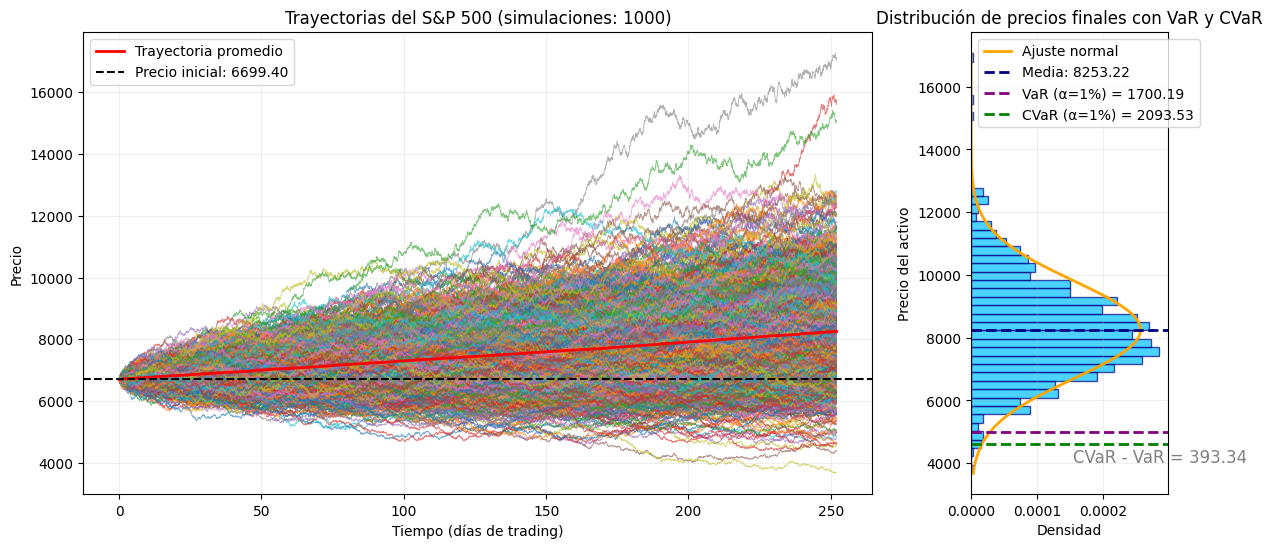

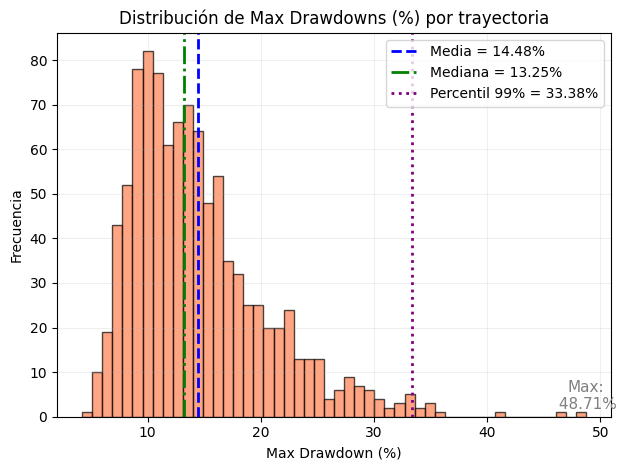

In [18]:
print("Generando gráficos...")

# Panel principal: trayectorias + distribución final
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [4, 1]})

# (a) Trayectorias simuladas
for i in range(min(n_trajectories, 1000)):
    axs[0].plot(time_grid, paths[i, :], linewidth=0.6, alpha=0.6)

avg_traj = np.mean(paths, axis=0)
axs[0].plot(time_grid, avg_traj, color="red", linewidth=2.0, label="Trayectoria promedio")
axs[0].axhline(S0, color="black", linestyle="--", linewidth=1.5, label=f"Precio inicial: {S0:.2f}")

axs[0].set_title(f"Trayectorias del S&P 500 (simulaciones: {n_trajectories})")
axs[0].set_xlabel("Tiempo (días de trading)")
axs[0].set_ylabel("Precio")
axs[0].legend()
axs[0].grid(alpha=0.2)

# (b) Distribución de precios finales con VaR, CVaR y Max Drawdown
mup, sigmap = norm.fit(final_prices)
x = np.linspace(final_prices.min(), final_prices.max(), 1000)
p = norm.pdf(x, mup, sigmap)

axs[1].hist(final_prices, bins=50, density=True, orientation='horizontal',
            color='deepskyblue', edgecolor='navy', alpha=0.7)
axs[1].plot(p, x, linewidth=2.0, color='orange', label='Ajuste normal')

axs[1].axhline(mup, color='navy', linestyle='--', linewidth=2, label=f"Media: {mup:.2f}")
axs[1].axhline(S0 - VaR, color='purple', linestyle='--', linewidth=2,
               label=f"VaR (α={alpha*100:.0f}%) = {VaR:.2f}")
axs[1].axhline(S0 - CVaR, color='green', linestyle='--', linewidth=2,
               label=f"CVaR (α={alpha*100:.0f}%) = {CVaR:.2f}")

diff = CVaR - VaR
y_min = final_prices.min()
axs[1].text(max(p)*0.6, y_min + (mup - y_min)*0.05,
            f"CVaR - VaR = {diff:.2f}", fontsize=12, color='grey', verticalalignment='bottom')

axs[1].set_title("Distribución de precios finales con VaR y CVaR")
axs[1].set_xlabel("Densidad")
axs[1].set_ylabel("Precio del activo")
axs[1].legend()
axs[1].grid(alpha=0.2)

plt.show()

# (c) Distribución de Max Drawdowns (%)
print('\n')
max_dds_pct = (max_dds / np.max(paths, axis=1)) * 100  # normalizar por el máximo de cada trayectoria

counts, bins, _ = plt.hist(max_dds_pct, bins=50, color='coral', edgecolor='black', alpha=0.7)

plt.title("Distribución de Max Drawdowns (%) por trayectoria")
plt.xlabel("Max Drawdown (%)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.2)

mean_dd = np.mean(max_dds_pct)
median_dd = np.median(max_dds_pct)
p99_dd = np.percentile(max_dds_pct, 99)
max_dd = np.max(max_dds_pct)

plt.axvline(mean_dd, color='blue', linestyle='--', linewidth=2, label=f"Media = {mean_dd:.2f}%")
plt.axvline(median_dd, color='green', linestyle='-.', linewidth=2, label=f"Mediana = {median_dd:.2f}%")
plt.axvline(p99_dd, color='purple', linestyle=':', linewidth=2, label=f"Percentil 99% = {p99_dd:.2f}%")

# Resaltar el máximo Max Drawdown
bin_idx = np.digitize(max_dd, bins) - 1
bin_height = counts[bin_idx] if 0 <= bin_idx < len(counts) else 0

plt.text(max_dd, bin_height + 1, f"Max:\n {max_dd:.2f}%",
         ha='center', va='bottom', fontsize=11, color='grey')

plt.legend()
plt.tight_layout()
plt.show()

### Referencias

Wilmott, P. (2006). Paul Wilmott on Quantitative Finance. John Wiley and Sons.

McKiney, W. (2017). Python for Data Analysis. O'Reilly Media.